In [1]:
import causaldag as cd
import save_utils
import numpy as np
import config
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.random.seed(1729)
sns.set()

In [2]:
def get_dags_folder(n, s):
    return os.path.join(config.DATA_FOLDER, 's={s}/n={n}'.format(s=s, n=n))

In [3]:
def save_dags(n, s, ndags):
    print('=== s={s}, n={n} ==='.format(s=s, n=n))
    run_folder = get_dags_folder(n, s)
    os.makedirs(run_folder)
    settings = {
        'nnodes': n,
        'sparsity': s,
        'ndags': ndags
    }
    save_utils.save_yaml(settings, os.path.join(run_folder, 'settings.yml'))

    dags = cd.random.directed_erdos(n, s, size=ndags)
    print('generated dags')
    cpdags = [d.cpdag for d in dags]
    print('computed cpdags')
    best_ivs = [d.optimal_intervention(cpdag=c) for d, c in zip(dags, cpdags)]
    icpdags = [d.interventional_cpdag([iv], cpdag=c) for d, c, iv in zip(dags, cpdags, best_ivs)]
    print('generated best interventional cpdag')
    num_unoriented = [len(c.edges) for c in cpdags]
    num_unoriented_intervened = [len(ic.edges) for ic in icpdags]
    for nu, nui in zip(num_unoriented, num_unoriented_intervened):
        if nui > nu:
            raise RuntimeError('you implemented something wrong dummy')        
    save_utils.save_list(num_unoriented, os.path.join(run_folder, 'num_unoriented.txt'))
    save_utils.save_list(num_unoriented_intervened, os.path.join(run_folder, 'num_unoriented_intervened.txt'))

    for i, (d, c) in enumerate(zip(dags, cpdags)):
        dag_folder = os.path.join(run_folder, 'dag%d' % i)
        os.makedirs(dag_folder)
        dag_amat, node_list = d.to_amat()
        cpdag_amat, _ = c.to_amat(node_list)
        np.save(os.path.join(dag_folder, 'dag.npy'), dag_amat)
        np.save(os.path.join(dag_folder, 'cpdag.npy'), cpdag_amat)

### Generate and save DAGs and CPDAGs

In [4]:
node_sizes = [3, 5, 8] + list(range(10, 101, 10))
ndags = 200
sparsities = [.1, .2, .5, .9]

In [5]:
for sparsity in sparsities:
    for n in node_sizes:
        save_dags(n, sparsity, ndags)

=== s=0.1, n=3 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=5 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=8 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=10 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=20 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=30 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=40 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=50 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=60 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=70 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=80 ===
generated dags
computed cpdags
generated best interventional cpdag
=== s=0.1, n=90 ===
generated dags
computed cp

In [6]:
for s in sparsities:
    for n in node_sizes:
        for d in range(ndags):
            dag_amat = np.load(os.path.join(get_dags_folder(n, s), 'dag%d' % d, 'dag.npy'))
            cpdag_amat = np.load(os.path.join(get_dags_folder(n, s), 'dag%d' % d, 'dag.npy'))

In [11]:
num_unoriented_mats = {s: np.zeros((len(node_sizes), ndags)) for s in sparsities}
for s in sparsities:
    for i, n in enumerate(node_sizes):
        num_unoriented_mats[s][i] = save_utils.load_list(os.path.join(get_dags_folder(n, s), 'num_unoriented.txt'))
num_unoriented_mats_intervened = {s: np.zeros((len(node_sizes), ndags)) for s in sparsities}
for s in sparsities:
    for i, n in enumerate(node_sizes):
        num_unoriented_mats_intervened[s][i] = save_utils.load_list(os.path.join(get_dags_folder(n, s), 'num_unoriented_intervened.txt'))

In [12]:
avg_num_unoriented = {s: np.mean(mat, axis=1) for s, mat in num_unoriented_mats.items()}
std_num_unoriented = {s: np.mean(mat, axis=1) for s, mat in num_unoriented_mats.items()}
percent_updag = {s: (mat==0).sum(axis=1)/ndags for s, mat in num_unoriented_mats.items()}

avg_num_unoriented_intervened = {s: np.mean(mat, axis=1) for s, mat in num_unoriented_mats_intervened.items()}
std_num_unoriented_intervened = {s: np.mean(mat, axis=1) for s, mat in num_unoriented_mats_intervened.items()}
percent_updag_intervened = {s: (mat==0).sum(axis=1)/ndags for s, mat in num_unoriented_mats_intervened.items()}

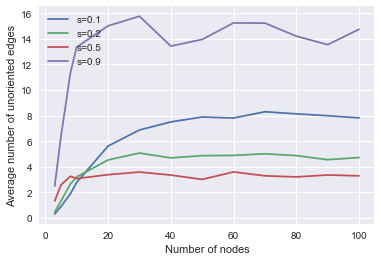

In [18]:
for s, color in zip(sparsities, sns.color_palette()):
    plt.plot(node_sizes, avg_num_unoriented[s], label='s={s}'.format(s=s), color=color)
#     plt.plot(node_sizes, avg_num_unoriented_intervened[s], label='s={s}'.format(s=s), linestyle='--', color=color)
plt.xlabel('Number of nodes')
plt.ylabel('Average number of unoriented edges')
plt.legend();

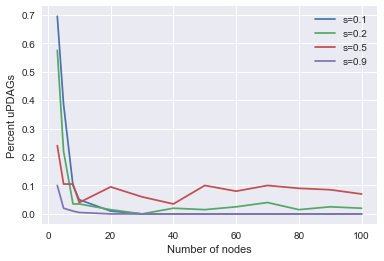

In [10]:
for s in sparsities:
    plt.plot(node_sizes, percent_updag[s], label='s={s}'.format(s=s))
plt.xlabel('Number of nodes')
plt.ylabel('Percent uPDAGs')
plt.legend();

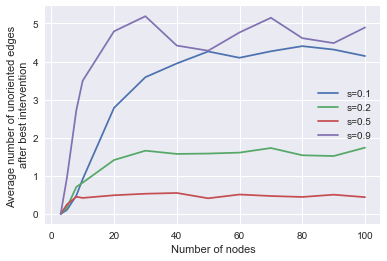

In [13]:
for s in sparsities:
    plt.errorbar(node_sizes, avg_num_unoriented_intervened[s], label='s={s}'.format(s=s))
plt.xlabel('Number of nodes')
plt.ylabel('Average number of unoriented edges \n after best intervention')
plt.legend();